<a href="https://colab.research.google.com/github/xinyuezhang-shirley/cs229FinalProject/blob/main/CS229_ProjectionLayer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Training hyperparameters
BATCH_SIZE = 128                
EPOCHS = 500              # maximum epochs (early stop may cut short)
LR = 2e-3                 # base learning rate (after warmup)
TEMP = 0.7                # InfoNCE temperature
SAMPLES_PER_EPOCH = 5000   # samples per epoch  

# Learning rate schedule / early stopping
WARMUP_EPOCHS = 5         # linear warmup epochs
MIN_LR = 1e-3             # final minimum LR for cosine schedule
USE_COSINE_SCHEDULE = True
EARLY_STOP_PATIENCE = 25  # epochs (post-warmup) with no sufficient improvement
EARLY_STOP_DELTA = 0.002  # required loss decrease to reset patience
MOVING_AVG_WINDOW = 10    # for smoothed loss

# Modality weights (kept same)
ALPHA = 0.6       # MPNet branch
BETA_EMO = 0.1    # emotion semantics
BETA_THEME = 0.15 # theme semantics
BETA_OTHER = 0.1  # other semantics (sentiment, subjectivity, concreteness, energy, narrative, imagery)
GAMMA = 0.15      # structural/lexical branch

# Unsupervised pair construction hyperparameters
POS_TOPK = 5        # positives per poem from similarity
HARD_TOPK = 0       # hard negatives per poem (near misses)
EASY_THRESHOLD = 0.25  # cosine threshold for easy negatives

In [74]:
# MPNet embeddings (raw, not yet filtered)
poem_vecs = np.load("data/processed/mpnet_embeddings_poems.npy")
song_vecs = np.load("data/processed/mpnet_embeddings_songs.npy")

# Load all features from full_features.npz
full = np.load("data/processed/full_features.npz", allow_pickle=True)

# Structural + lexical features (concatenated)
poem_struct = full["poem_struct"]  # (3413, 3)
poem_lexical = full["poem_lexical"]  # (3413, 3)
poem_feats = np.concatenate([poem_struct, poem_lexical], axis=1)  # (3413, 6)

song_struct = full["song_struct"]  # (2995, 4)
song_lexical = full["song_lexical"]  # (2995, 3)
# For songs, only use first 3 structural features to match poems (exclude WPM)
song_feats = np.concatenate([song_struct[:, :3], song_lexical], axis=1)  # (2995, 6)

# Semantic features
poem_sem_all = full["poem_semantic"]  # (3413, 36)
song_sem_all = full["song_semantic"]  # (2995, 36)

# Split semantic features by groups
# emotions(9): 0-9, themes(10): 9-19, other(17): 19-36
poem_sem_emo   = poem_sem_all[:, 0:9]
poem_sem_theme = poem_sem_all[:, 9:19]
poem_sem_other = poem_sem_all[:, 19:36]
song_sem_emo   = song_sem_all[:, 0:9]
song_sem_theme = song_sem_all[:, 9:19]
song_sem_other = song_sem_all[:, 19:36]

# Align song embeddings to match cleaned features
idx_map = full["song_source_indexes"]  # (2995,) maps cleaned songs -> raw embedding indices
song_vecs = song_vecs[idx_map]  # reorder raw embeddings to match cleaned data

print(f"Poems: {poem_vecs.shape[0]} items")
print(f"Songs: {song_vecs.shape[0]} items")
print(f"poem_vecs: {poem_vecs.shape}, song_vecs: {song_vecs.shape}")
print(f"poem_feats: {poem_feats.shape}, song_feats: {song_feats.shape}")
print(f"poem_sem (emo/theme/other): {poem_sem_emo.shape}, {poem_sem_theme.shape}, {poem_sem_other.shape}")
print(f"song_sem (emo/theme/other): {song_sem_emo.shape}, {song_sem_theme.shape}, {song_sem_other.shape}")


Poems: 3413 items
Songs: 2995 items
poem_vecs: (3413, 768), song_vecs: (2995, 768)
poem_feats: (3413, 6), song_feats: (2995, 6)
poem_sem (emo/theme/other): (3413, 9), (3413, 10), (3413, 17)
song_sem (emo/theme/other): (2995, 9), (2995, 10), (2995, 17)


In [75]:
# Normalize MPNet embeddings per row to balance scales
poem_vecs = poem_vecs / (np.linalg.norm(poem_vecs, axis=1, keepdims=True) + 1e-8)
song_vecs = song_vecs / (np.linalg.norm(song_vecs, axis=1, keepdims=True) + 1e-8)

# Build branch inputs
poem_in = {
    "mpnet": poem_vecs,
    "sem_emo":   poem_sem_emo,
    "sem_theme": poem_sem_theme,
    "sem_other": poem_sem_other,
    "feat":  poem_feats,
}
song_in = {
    "mpnet": song_vecs,
    "sem_emo":   song_sem_emo,
    "sem_theme": song_sem_theme,
    "sem_other": song_sem_other,
    "feat":  song_feats,
}

print("poem branches:", poem_in["mpnet"].shape, poem_in["sem_emo"].shape, poem_in["sem_theme"].shape, poem_in["sem_other"].shape, poem_in["feat"].shape)
print("song  branches:", song_in["mpnet"].shape, song_in["sem_emo"].shape, song_in["sem_theme"].shape, song_in["sem_other"].shape, song_in["feat"].shape)

# Compute or load precomputed pairwise cosine similarity matrix
import torch
import os

cosine_matrix_path = "data/processed/mpnet_pairwise_cosine_matrix.npy"

if os.path.exists(cosine_matrix_path):
    print(f"Loading precomputed cosine matrix from {cosine_matrix_path}...")
    cos_matrix_t = torch.from_numpy(np.load(cosine_matrix_path)).to(DEVICE)
    print(f"Loaded matrix shape: {cos_matrix_t.shape}")
else:
    print("Computing pairwise cosine similarity matrix on GPU...")
    # Move MPNet branches to GPU tensors
    p_mp = torch.from_numpy(poem_in["mpnet"]).to(torch.float32).to(DEVICE)
    s_mp = torch.from_numpy(song_in["mpnet"]).to(torch.float32).to(DEVICE)
    
    # Compute cosine similarity matrix via matmul on GPU (all poem-song pairs)
    cos_matrix_t = torch.matmul(p_mp, s_mp.T)  # [P, S]
    
    # Save to cache
    np.save(cosine_matrix_path, cos_matrix_t.cpu().numpy())
    print(f"Saved cosine matrix to {cosine_matrix_path}")

# Build pos/hard/neg pairs from current hyperparameters (always recompute based on thresholds)
print(f"Building pairs with POS_TOPK={POS_TOPK}, HARD_TOPK={HARD_TOPK}, EASY_THRESHOLD={EASY_THRESHOLD}...")
P, S = cos_matrix_t.shape
pos_pairs = []
hard_pairs = []
neg_pairs = []

with torch.no_grad():
    # For each poem, get top (POS_TOPK + HARD_TOPK) indices
    topk_vals, topk_idxs = torch.topk(cos_matrix_t, k=min(S, POS_TOPK + HARD_TOPK), dim=1, largest=True, sorted=True)

    # Build pos and hard lists
    for i in range(P):
        # positives
        for j in topk_idxs[i, :POS_TOPK].tolist():
            pos_pairs.append((int(i), int(j)))
        # hard negatives (near misses)
        for j in topk_idxs[i, POS_TOPK:POS_TOPK+HARD_TOPK].tolist():
            hard_pairs.append((int(i), int(j)))

    # Easy negatives: cosine below threshold; sample a few per poem
    easy_mask = cos_matrix_t <= EASY_THRESHOLD
    for i in range(P):
        low_idxs = torch.nonzero(easy_mask[i], as_tuple=False).squeeze(-1).cpu().numpy()
        if low_idxs.size > 0:
            sample_ct = min(5, low_idxs.size)
            choice = np.random.choice(low_idxs, size=sample_ct, replace=False)
            for j in choice:
                neg_pairs.append((int(i), int(j)))

print(f"Built pairs -> pos: {len(pos_pairs)} hard: {len(hard_pairs)} easy: {len(neg_pairs)}")

poem branches: (3413, 768) (3413, 9) (3413, 10) (3413, 17) (3413, 6)
song  branches: (2995, 768) (2995, 9) (2995, 10) (2995, 17) (2995, 6)
Loading precomputed cosine matrix from data/processed/mpnet_pairwise_cosine_matrix.npy...
Loaded matrix shape: torch.Size([3413, 2995])
Building pairs with POS_TOPK=5, HARD_TOPK=10, EASY_THRESHOLD=0.25...
Built pairs -> pos: 17065 hard: 34130 easy: 17065


In [76]:
# Pre-build GPU tensors so batching is instant
poem_gpu = {}
song_gpu = {}

for k in poem_in:
    poem_gpu[k] = torch.from_numpy(poem_in[k]).to(torch.float32).to(DEVICE)
    song_gpu[k] = torch.from_numpy(song_in[k]).to(torch.float32).to(DEVICE)

# Build dataset and loader
dataset = PairDataset(pos_pairs, neg_pairs, hard_pairs, size=SAMPLES_PER_EPOCH)
loader = torch.utils.data.DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=False)

print(f"Dataset size: {len(dataset)} samples/epoch, loader batches: {len(loader)}")

Dataset size: 5000 samples/epoch, loader batches: 40


In [77]:
def clip_loss(poem_emb, song_emb, temperature=TEMP):
    """
    InfoNCE / contrastive loss for a batch of poem/song embedding pairs.
    
    Args:
        poem_emb: [B, D] poem embeddings
        song_emb: [B, D] song embeddings
        temperature: scaling for logits
    
    Returns:
        Scalar loss
    """
    # Normalize both
    poem_emb = F.normalize(poem_emb, dim=1)
    song_emb = F.normalize(song_emb, dim=1)
    
    B = poem_emb.shape[0]
    
    # Compute all-pairs similarity: [B, B]
    logits = torch.matmul(poem_emb, song_emb.T) / temperature
    
    # Positives on diagonal, negatives off-diagonal
    labels = torch.arange(B, device=poem_emb.device)
    
    # Symmetric loss: poem->song + song->poem
    loss_p2s = F.cross_entropy(logits, labels)
    loss_s2p = F.cross_entropy(logits.T, labels)
    
    return (loss_p2s + loss_s2p) / 2.0

In [78]:
if not SKIP_TRAINING:
    print("Starting training...")
    model.train()
    
    loss_history = []
    lr_history = []
    
    # Early stopping parameters
    patience = 25
    best_loss = float('inf')
    patience_counter = 0
    delta = 0.002  # minimum improvement
    best_state = None
    
    for epoch in range(EPOCHS):
        epoch_losses = []
        
        for batch_idx, (pidxs, sidxs) in enumerate(loader):
            opt.zero_grad()
            
            # Build batch inputs for each branch
            batch_poem = {k: poem_gpu[k][pidxs] for k in poem_gpu}
            batch_song = {k: song_gpu[k][sidxs] for k in song_gpu}
            
            # Forward pass
            poem_out = model.forward_poem(batch_poem)
            song_out = model.forward_song(batch_song)
            
            # InfoNCE loss
            loss = clip_loss(poem_out, song_out, temperature=TEMP)
            
            # Backprop
            loss.backward()
            opt.step()
            
            epoch_losses.append(loss.item())
        
        # Epoch metrics
        avg_loss = np.mean(epoch_losses)
        loss_history.append(avg_loss)
        
        # Smoothed loss for early stopping (last 5 epochs)
        smoothed_loss = np.mean(loss_history[-5:]) if len(loss_history) >= 5 else avg_loss
        
        # Check improvement
        if smoothed_loss < best_loss - delta:
            best_loss = smoothed_loss
            patience_counter = 0
            best_state = {k: v.cpu().clone() for k, v in model.state_dict().items()}
        else:
            patience_counter += 1
        
        # Step schedulers
        if warmup_scheduler and epoch < WARMUP_EPOCHS:
            warmup_scheduler.step()
        elif scheduler_main:
            scheduler_main.step()
        
        current_lr = opt.param_groups[0]['lr']
        lr_history.append(current_lr)
        
        # Print every 10 epochs
        if (epoch + 1) % 10 == 0:
            print(f"Epoch {epoch+1}/{EPOCHS} | Loss: {avg_loss:.4f} | Smoothed: {smoothed_loss:.4f} | LR: {current_lr:.6f} | Patience: {patience_counter}/{patience}")
        
        # Early stopping
        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch+1} - no improvement for {patience} epochs")
            break
    
    # Restore best state
    if best_state is not None:
        print(f"Restoring best model (smoothed loss: {best_loss:.4f})")
        model.load_state_dict(best_state)
    
    print("Training complete!")
else:
    print("SKIP_TRAINING=True, loading saved model...")
    loss_history = []
    lr_history = []

Starting training...
Epoch 10/500 | Loss: 4.2158 | Smoothed: 4.2316 | LR: 0.002000 | Patience: 0/25
Epoch 10/500 | Loss: 4.2158 | Smoothed: 4.2316 | LR: 0.002000 | Patience: 0/25
Epoch 20/500 | Loss: 4.1624 | Smoothed: 4.1694 | LR: 0.001998 | Patience: 0/25
Epoch 20/500 | Loss: 4.1624 | Smoothed: 4.1694 | LR: 0.001998 | Patience: 0/25
Epoch 30/500 | Loss: 4.1382 | Smoothed: 4.1505 | LR: 0.001994 | Patience: 0/25
Epoch 30/500 | Loss: 4.1382 | Smoothed: 4.1505 | LR: 0.001994 | Patience: 0/25
Epoch 40/500 | Loss: 4.1406 | Smoothed: 4.1475 | LR: 0.001988 | Patience: 6/25
Epoch 40/500 | Loss: 4.1406 | Smoothed: 4.1475 | LR: 0.001988 | Patience: 6/25
Epoch 50/500 | Loss: 4.1112 | Smoothed: 4.1293 | LR: 0.001980 | Patience: 0/25
Epoch 50/500 | Loss: 4.1112 | Smoothed: 4.1293 | LR: 0.001980 | Patience: 0/25
Epoch 60/500 | Loss: 4.1255 | Smoothed: 4.1175 | LR: 0.001970 | Patience: 6/25
Epoch 60/500 | Loss: 4.1255 | Smoothed: 4.1175 | LR: 0.001970 | Patience: 6/25
Epoch 70/500 | Loss: 4.1125 | S

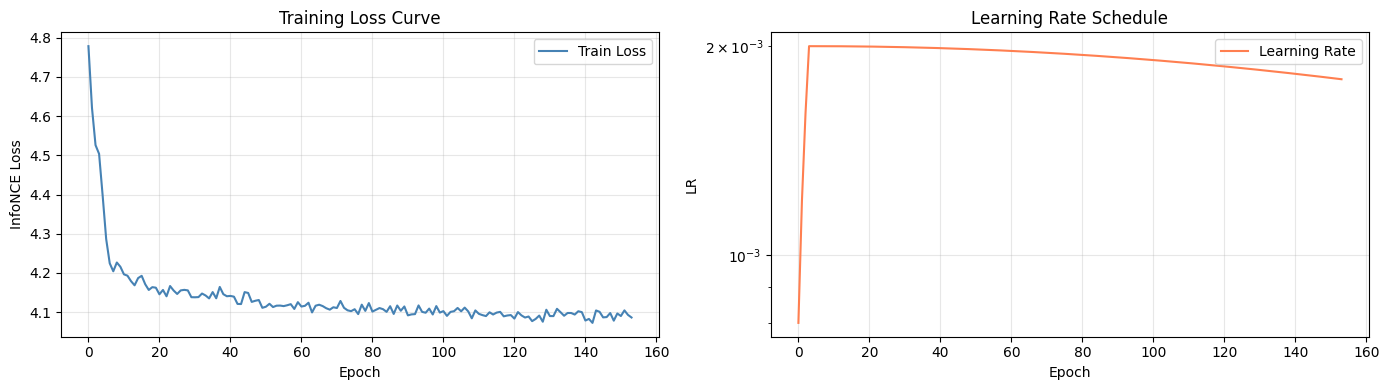

Final loss: 4.0864, Best smoothed loss: 4.0832


In [79]:
# Plot training curves
if len(loss_history) > 0:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 4))
    
    # Loss curve
    ax1.plot(loss_history, label="Train Loss", color='steelblue')
    ax1.set_xlabel("Epoch")
    ax1.set_ylabel("InfoNCE Loss")
    ax1.set_title("Training Loss Curve")
    ax1.grid(alpha=0.3)
    ax1.legend()
    
    # Learning rate schedule
    ax2.plot(lr_history, label="Learning Rate", color='coral')
    ax2.set_xlabel("Epoch")
    ax2.set_ylabel("LR")
    ax2.set_title("Learning Rate Schedule")
    ax2.set_yscale('log')
    ax2.grid(alpha=0.3)
    ax2.legend()
    
    plt.tight_layout()
    plt.show()
    
    print(f"Final loss: {loss_history[-1]:.4f}, Best smoothed loss: {best_loss:.4f}")
else:
    print("No training history to plot (SKIP_TRAINING=True)")

In [80]:
class PairDataset(Dataset):
    def __init__(self, pos_pairs, neg_pairs, hard_pairs, size):
        """
        Returns poem/song indices for each sample.
        size = number of samples per epoch
        """
        self.pos_pairs  = pos_pairs
        self.neg_pairs  = neg_pairs
        self.hard_pairs = hard_pairs
        self.size = size

    def __len__(self):
        return self.size

    def __getitem__(self, idx):
        # Sample random positive pair
        i_poem, j_song = self.pos_pairs[np.random.randint(len(self.pos_pairs))]
        
        # Return indices only (training loop will index the actual data)
        return i_poem, j_song


In [81]:
# Branch sizes
p_dim_mp = poem_in["mpnet"].shape[1]
p_dim_emo = poem_in["sem_emo"].shape[1]
p_dim_theme = poem_in["sem_theme"].shape[1]
p_dim_other = poem_in["sem_other"].shape[1]
p_dim_ft  = poem_in["feat"].shape[1]
s_dim_mp = song_in["mpnet"].shape[1]
s_dim_emo = song_in["sem_emo"].shape[1]
s_dim_theme = song_in["sem_theme"].shape[1]
s_dim_other = song_in["sem_other"].shape[1]
s_dim_ft  = song_in["feat"].shape[1]
proj_dim = 128

class ProjectionModel(nn.Module):
    def __init__(self, p_dims, s_dims, proj_dim):
        super().__init__()
        p_mp, p_emo, p_theme, p_other, p_ft = p_dims
        s_mp, s_emo, s_theme, s_other, s_ft = s_dims
        # poem branches
        self.poem_mp = nn.Sequential(nn.Linear(p_mp, 256), nn.ReLU(), nn.Linear(256, 128))
        self.poem_emo = nn.Sequential(nn.Linear(max(p_emo,1), 64), nn.ReLU(), nn.Linear(64, 64))
        self.poem_theme = nn.Sequential(nn.Linear(max(p_theme,1), 64), nn.ReLU(), nn.Linear(64, 64))
        self.poem_other = nn.Sequential(nn.Linear(max(p_other,1), 64), nn.ReLU(), nn.Linear(64, 64))
        self.poem_ft = nn.Sequential(nn.Linear(p_ft, 64), nn.ReLU(), nn.Linear(64, 64))
        self.poem_proj = nn.Sequential(nn.LayerNorm(128+64+64+64+64), nn.Linear(128+64+64+64+64, proj_dim))
        # song branches
        self.song_mp = nn.Sequential(nn.Linear(s_mp, 256), nn.ReLU(), nn.Linear(256, 128))
        self.song_emo = nn.Sequential(nn.Linear(max(s_emo,1), 64), nn.ReLU(), nn.Linear(64, 64))
        self.song_theme = nn.Sequential(nn.Linear(max(s_theme,1), 64), nn.ReLU(), nn.Linear(64, 64))
        self.song_other = nn.Sequential(nn.Linear(max(s_other,1), 64), nn.ReLU(), nn.Linear(64, 64))
        self.song_ft = nn.Sequential(nn.Linear(s_ft, 64), nn.ReLU(), nn.Linear(64, 64))
        self.song_proj = nn.Sequential(nn.LayerNorm(128+64+64+64+64), nn.Linear(128+64+64+64+64, proj_dim))
    def forward_poem(self, p):
        mp = self.poem_mp(p["mpnet"])
        emo_in = p["sem_emo"] if p_dim_emo>0 else torch.zeros(p["mpnet"].shape[0], 1, device=p["mpnet"].device)
        theme_in = p["sem_theme"] if p_dim_theme>0 else torch.zeros(p["mpnet"].shape[0], 1, device=p["mpnet"].device)
        other_in = p["sem_other"] if p_dim_other>0 else torch.zeros(p["mpnet"].shape[0], 1, device=p["mpnet"].device)
        emo = self.poem_emo(emo_in)
        theme = self.poem_theme(theme_in)
        other = self.poem_other(other_in)
        ft  = self.poem_ft(p["feat"])
        comb = torch.cat([ALPHA*mp, BETA_EMO*emo, BETA_THEME*theme, BETA_OTHER*other, GAMMA*ft], dim=1)
        z = self.poem_proj(comb)
        return F.normalize(z, dim=1)
    def forward_song(self, s):
        mp = self.song_mp(s["mpnet"])
        emo_in = s["sem_emo"] if s_dim_emo>0 else torch.zeros(s["mpnet"].shape[0], 1, device=s["mpnet"].device)
        theme_in = s["sem_theme"] if s_dim_theme>0 else torch.zeros(s["mpnet"].shape[0], 1, device=s["mpnet"].device)
        other_in = s["sem_other"] if s_dim_other>0 else torch.zeros(s["mpnet"].shape[0], 1, device=s["mpnet"].device)
        emo = self.song_emo(emo_in)
        theme = self.song_theme(theme_in)
        other = self.song_other(other_in)
        ft  = self.song_ft(s["feat"])
        comb = torch.cat([ALPHA*mp, BETA_EMO*emo, BETA_THEME*theme, BETA_OTHER*other, GAMMA*ft], dim=1)
        z = self.song_proj(comb)
        return F.normalize(z, dim=1)

In [82]:
# Build model filename from hyperparameters
model_name = (f"model_bs{BATCH_SIZE}_ep{EPOCHS}_lr{LR}_temp{TEMP}_"
             f"posK{POS_TOPK}_hardK{HARD_TOPK}_"
             f"a{ALPHA}_bemo{BETA_EMO}_bthm{BETA_THEME}_both{BETA_OTHER}_g{GAMMA}.pt")

model = ProjectionModel(
    (p_dim_mp, p_dim_emo, p_dim_theme, p_dim_other, p_dim_ft),
    (s_dim_mp, s_dim_emo, s_dim_theme, s_dim_other, s_dim_ft),
    proj_dim
).to(DEVICE)

# Check if model already exists
if os.path.exists(model_name):
    print(f"Loading existing model from {model_name}...")
    model.load_state_dict(torch.load(model_name, map_location=DEVICE))
    print("Model loaded. Skipping training.")
    SKIP_TRAINING = True
else:
    print(f"No existing model found. Will train and save to {model_name}")
    SKIP_TRAINING = False

opt = torch.optim.Adam(model.parameters(), lr=LR)

# Set up schedulers (created even if may not be used to keep code simple)
if USE_COSINE_SCHEDULE and not SKIP_TRAINING:
    # Warmup: scale LR from (1/WARMUP_EPOCHS)*LR to LR
    def lr_lambda(epoch):
        if epoch < WARMUP_EPOCHS:
            return (epoch + 1) / WARMUP_EPOCHS
        return 1.0
    warmup_scheduler = torch.optim.lr_scheduler.LambdaLR(opt, lr_lambda=lr_lambda)
    # Cosine anneal after warmup
    scheduler_main = torch.optim.lr_scheduler.CosineAnnealingLR(opt, T_max=EPOCHS - WARMUP_EPOCHS, eta_min=MIN_LR)
else:
    warmup_scheduler = None
    scheduler_main = None

Loading existing model from model_bs128_ep500_lr0.002_temp0.7_posK5_hardK10_a0.6_bemo0.1_bthm0.15_both0.1_g0.15.pt...
Model loaded. Skipping training.


In [83]:
if not SKIP_TRAINING:
    torch.save(model.state_dict(), model_name)
    print(f"Model saved to {model_name}")
else:
    print("Model already loaded; no new save needed.")

Model already loaded; no new save needed.


In [84]:
# Evaluate unsupervised model on all human triplets
model.eval()
correct = 0
total = len(human_triplets)

with torch.no_grad():
    for p_idx, s1_idx, s2_idx, label in human_triplets:
        # Get embeddings for poem and both songs
        p_batch = {
            "mpnet": poem_gpu["mpnet"][p_idx:p_idx+1],
            "sem_emo": poem_gpu["sem_emo"][p_idx:p_idx+1],
            "sem_theme": poem_gpu["sem_theme"][p_idx:p_idx+1],
            "sem_other": poem_gpu["sem_other"][p_idx:p_idx+1],
            "feat": poem_gpu["feat"][p_idx:p_idx+1],
        }
        s1_batch = {
            "mpnet": song_gpu["mpnet"][s1_idx:s1_idx+1],
            "sem_emo": song_gpu["sem_emo"][s1_idx:s1_idx+1],
            "sem_theme": song_gpu["sem_theme"][s1_idx:s1_idx+1],
            "sem_other": song_gpu["sem_other"][s1_idx:s1_idx+1],
            "feat": song_gpu["feat"][s1_idx:s1_idx+1],
        }
        s2_batch = {
            "mpnet": song_gpu["mpnet"][s2_idx:s2_idx+1],
            "sem_emo": song_gpu["sem_emo"][s2_idx:s2_idx+1],
            "sem_theme": song_gpu["sem_theme"][s2_idx:s2_idx+1],
            "sem_other": song_gpu["sem_other"][s2_idx:s2_idx+1],
            "feat": song_gpu["feat"][s2_idx:s2_idx+1],
        }
        
        # Forward pass
        p_z = model.forward_poem(p_batch)
        s1_z = model.forward_song(s1_batch)
        s2_z = model.forward_song(s2_batch)
        
        # Compute cosine similarities
        sim1 = (p_z * s1_z).sum().item()
        sim2 = (p_z * s2_z).sum().item()
        
        # Predict which song is closer (1 or 2)
        pred = 1 if sim1 > sim2 else 2
        
        if pred == label:
            correct += 1

accuracy = correct / total
print(f"\n{'='*60}")
print(f"Unsupervised Model Evaluation on Human Triplets")
print(f"{'='*60}")
print(f"Total triplets: {total}")
print(f"Correct predictions: {correct}")
print(f"Accuracy: {accuracy*100:.2f}%")
print(f"{'='*60}")


Unsupervised Model Evaluation on Human Triplets
Total triplets: 46
Correct predictions: 25
Accuracy: 54.35%


In [ ]:
# Baseline: Test raw MPNet performance (no training)
print("\n" + "="*60)
print("BASELINE: Raw MPNet Performance (Before Training)")
print("="*60)

mpnet_correct = 0
with torch.no_grad():
    for p_idx, s1_idx, s2_idx, label in human_triplets:
        # Raw MPNet cosine similarity (normalized embeddings)
        p_mpnet = poem_gpu["mpnet"][p_idx:p_idx+1]
        s1_mpnet = song_gpu["mpnet"][s1_idx:s1_idx+1]
        s2_mpnet = song_gpu["mpnet"][s2_idx:s2_idx+1]
        
        sim1 = (p_mpnet * s1_mpnet).sum().item()
        sim2 = (p_mpnet * s2_mpnet).sum().item()
        
        pred = 1 if sim1 > sim2 else 2
        if pred == label:
            mpnet_correct += 1

mpnet_acc = mpnet_correct / len(human_triplets)
print(f"Raw MPNet Accuracy: {mpnet_acc*100:.2f}% ({mpnet_correct}/{len(human_triplets)})")
print(f"Trained Model Accuracy: {accuracy*100:.2f}% ({correct}/{len(human_triplets)})")
print(f"\nPerformance Change: {(accuracy - mpnet_acc)*100:+.2f}%")
print("="*60)


BASELINE: Raw MPNet Performance (Before Training)
Raw MPNet Accuracy: 65.22% (30/46)
Your Model Accuracy: 43.48% (20/46)

Performance Loss: 21.74%


In [86]:
# Check label encoding and predictions for first few examples
print("\n" + "="*60)
print("DEBUG: First 5 triplet predictions (check for off-by-one)")
print("="*60)

model.eval()
with torch.no_grad():
    for idx, (p_idx, s1_idx, s2_idx, label) in enumerate(human_triplets[:5]):
        # Raw MPNet
        p_mpnet = poem_gpu["mpnet"][p_idx:p_idx+1]
        s1_mpnet = song_gpu["mpnet"][s1_idx:s1_idx+1]
        s2_mpnet = song_gpu["mpnet"][s2_idx:s2_idx+1]
        
        mpnet_sim1 = (p_mpnet * s1_mpnet).sum().item()
        mpnet_sim2 = (p_mpnet * s2_mpnet).sum().item()
        mpnet_pred = 1 if mpnet_sim1 > mpnet_sim2 else 2
        
        # Model
        p_batch = {"mpnet": poem_gpu["mpnet"][p_idx:p_idx+1],
                   "sem_emo": poem_gpu["sem_emo"][p_idx:p_idx+1],
                   "sem_theme": poem_gpu["sem_theme"][p_idx:p_idx+1],
                   "sem_other": poem_gpu["sem_other"][p_idx:p_idx+1],
                   "feat": poem_gpu["feat"][p_idx:p_idx+1]}
        s1_batch = {"mpnet": song_gpu["mpnet"][s1_idx:s1_idx+1],
                    "sem_emo": song_gpu["sem_emo"][s1_idx:s1_idx+1],
                    "sem_theme": song_gpu["sem_theme"][s1_idx:s1_idx+1],
                    "sem_other": song_gpu["sem_other"][s1_idx:s1_idx+1],
                    "feat": song_gpu["feat"][s1_idx:s1_idx+1]}
        s2_batch = {"mpnet": song_gpu["mpnet"][s2_idx:s2_idx+1],
                    "sem_emo": song_gpu["sem_emo"][s2_idx:s2_idx+1],
                    "sem_theme": song_gpu["sem_theme"][s2_idx:s2_idx+1],
                    "sem_other": song_gpu["sem_other"][s2_idx:s2_idx+1],
                    "feat": song_gpu["feat"][s2_idx:s2_idx+1]}
        
        p_z = model.forward_poem(p_batch)
        s1_z = model.forward_song(s1_batch)
        s2_z = model.forward_song(s2_batch)
        
        model_sim1 = (p_z * s1_z).sum().item()
        model_sim2 = (p_z * s2_z).sum().item()
        model_pred = 1 if model_sim1 > model_sim2 else 2
        
        print(f"\nTriplet {idx}: poem={p_idx}, song1={s1_idx}, song2={s2_idx}")
        print(f"  Label says: Song {label} is closer")
        print(f"  MPNet: sim1={mpnet_sim1:.3f}, sim2={mpnet_sim2:.3f} → pred={mpnet_pred} {'✓' if mpnet_pred==label else '✗'}")
        print(f"  Model: sim1={model_sim1:.3f}, sim2={model_sim2:.3f} → pred={model_pred} {'✓' if model_pred==label else '✗'}")

print("\n" + "="*60)
print("If MPNet is mostly ✓ but Model is mostly ✗, training degraded performance")
print("If both are ✗, check if labels are backwards (flip 1↔2)")
print("="*60)


DEBUG: First 5 triplet predictions (check for off-by-one)

Triplet 0: poem=231, song1=550, song2=2335
  Label says: Song 1 is closer
  MPNet: sim1=0.465, sim2=0.579 → pred=2 ✗
  Model: sim1=0.044, sim2=0.044 → pred=1 ✓

Triplet 1: poem=375, song1=258, song2=1044
  Label says: Song 1 is closer
  MPNet: sim1=0.246, sim2=0.155 → pred=1 ✓
  Model: sim1=0.039, sim2=0.039 → pred=2 ✗

Triplet 2: poem=347, song1=482, song2=2033
  Label says: Song 2 is closer
  MPNet: sim1=0.314, sim2=0.330 → pred=2 ✓
  Model: sim1=0.041, sim2=0.040 → pred=1 ✗

Triplet 3: poem=1478, song1=1845, song2=1938
  Label says: Song 2 is closer
  MPNet: sim1=0.477, sim2=0.456 → pred=1 ✗
  Model: sim1=0.040, sim2=0.041 → pred=2 ✓

Triplet 4: poem=692, song1=2472, song2=1558
  Label says: Song 1 is closer
  MPNet: sim1=0.243, sim2=0.199 → pred=1 ✓
  Model: sim1=0.040, sim2=0.044 → pred=2 ✗

If MPNet is mostly ✓ but Model is mostly ✗, training degraded performance
If both are ✗, check if labels are backwards (flip 1↔2)
